# Digital Image Processing — Lecture 06 Code
## Introduction
In this lab, we will explore advanced morphological algorithms used in Digital 2. Image Processing. Based on the lecture materials, we will cover:<br>
1. Hit-or-Miss Transform (HMT) 
2. Boundary Extraction & Region Filling 
3. Thinning & Thickening 
4. Gray Level Morphology (Gradients, Top-Hat) 
5. Connected Components Labeling 
6. Region Properties (Centroid, Circularity)

### Libraries and Helper Function

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Helper function to display images
def show_images(images, titles, cmap='gray'):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis('off')
    plt.show()


## 1. Hit-or-Miss Transform (HMT)
The Hit-or-Miss transform is used to detect specific shapes or patterns. It asks: "Does the foreground match pattern $B_1$ AND does the background match pattern $B_2$?".

Formula:$$A \circledast B = (A \ominus B_1) \cap (A^c \ominus B_2)$$

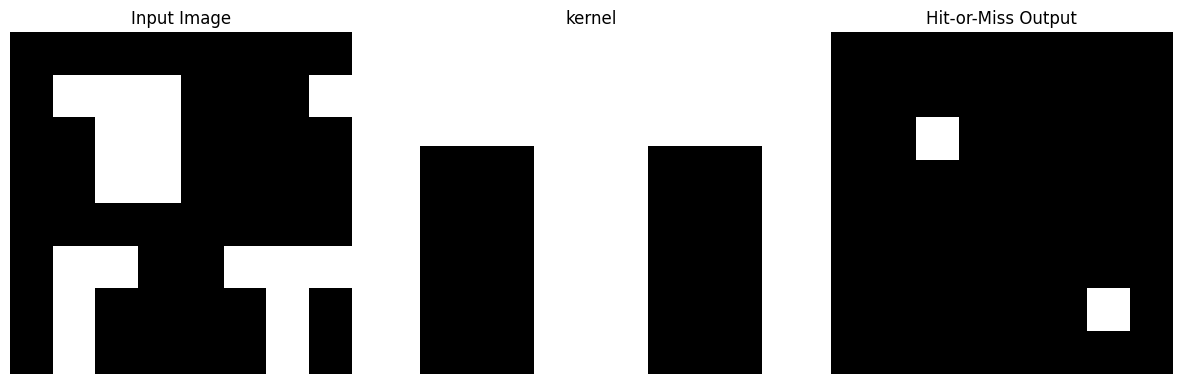

In [21]:
# Create the input image
input_image = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 255, 0, 0, 0, 255],
    [0, 0, 255, 255, 0, 0, 0, 0],
    [0, 0, 255, 255, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 0, 0, 255, 255, 255],
    [0,255, 0, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 0, 255, 0]], dtype="uint8")
cv2.imshow("img_in",input_image)

# Construct the structuring element
kernel = np.array((
        [1, 1, 1],
        [0, 1, 0],
        [0, 1, 0]), dtype="uint8")

# Apply hit-or-miss transformation
output_image = cv2.morphologyEx(input_image, cv2.MORPH_HITMISS, kernel)

# Display the results
show_images([input_image, kernel, output_image], ["Input Image","kernel", "Hit-or-Miss Output"])

# 2. Boundary Extraction
We can extract the boundary $\beta(A)$ of an object by eroding the original object $A$ and subtracting the result from $A$ .<br> **Formula:**$$\beta(A) = A - (A \ominus B)$$

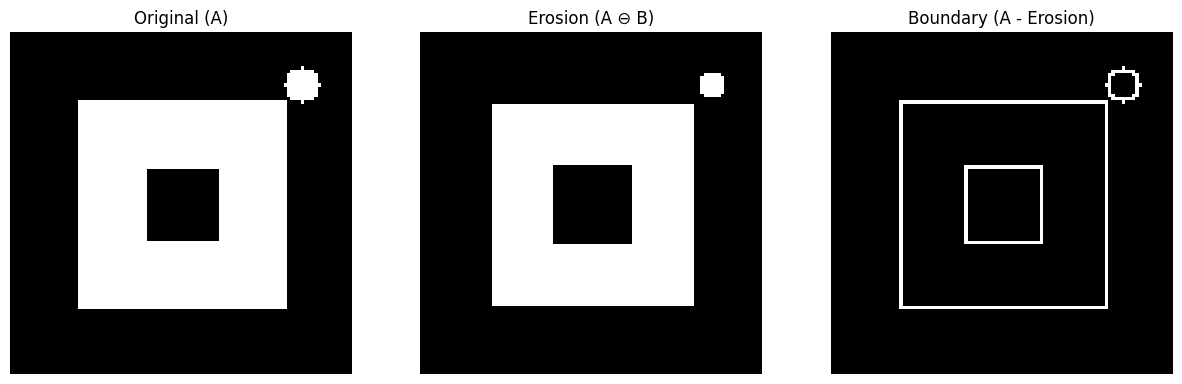

In [22]:
# Define Structuring Element (3x3 box)
img_binary = np.zeros((100, 100), dtype=np.uint8)
cv2.rectangle(img_binary, (20, 20), (80, 80), 255, -1) # Big square
cv2.rectangle(img_binary, (40, 40), (60, 60), 0, -1)   # Hole in middle
cv2.circle(img_binary, (85, 15), 5, 255, -1)           # Small noise dot
kernel = np.ones((3,3), np.uint8)

# 1. Erode the image
erosion = cv2.erode(img_binary, kernel, iterations=1)

# 2. Subtract erosion from original
boundary = img_binary - erosion

show_images([img_binary, erosion, boundary], ["Original (A)", "Erosion (A ⊖ B)", "Boundary (A - Erosion)"])

## 3. Region (Hole) Filling
Given a seed point inside a boundary, we can fill the hole using iterative dilation intersected with the complement of the boundary.<br>**Formula:**$$X_{k+1} = (X_k \oplus B) \cap A^c$$

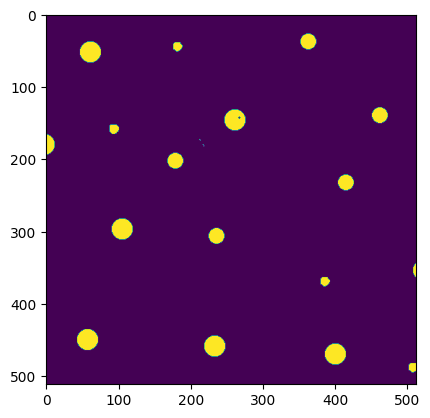

In [ ]:
import cv2
import numpy as np

# Read image
original_image = cv2.imread('Fig0916(a)(region-filling-reflections).tif',
                            cv2.IMREAD_GRAYSCALE)

# Threshold to binary (ensure 0/255)
_, binary = cv2.threshold(original_image, 128, 255, cv2.THRESH_BINARY)

# Copy for flood filling
flood = binary.copy()

# Mask needs to be 2 pixels bigger than the image
h, w = binary.shape
mask = np.zeros((h+2, w+2), np.uint8)

# Flood fill from (0,0)
cv2.floodFill(flood, mask, (0,0), 255)

# Invert flood-filled image
flood_inv = cv2.bitwise_not(flood)

# Combine with original to fill holes
filled_hole_image = binary | flood_inv

show_images([binary, flood_inv, filled_hole_image],
            ["Original Binary", "Inverted Flood Fill", "Filled Holes"])

In [12]:
!pip install opencv-contrib-python

^C


## 4. Boundary Extraction
 We extract the boundary of an object by subtracting the eroded version of the image from the original image. This leaves only the pixels that are on the edge.<br>**Math Formula:**$$\beta(A) = A - (A \ominus B)$$Where $A$ is the original image and $B$ is the structuring element.

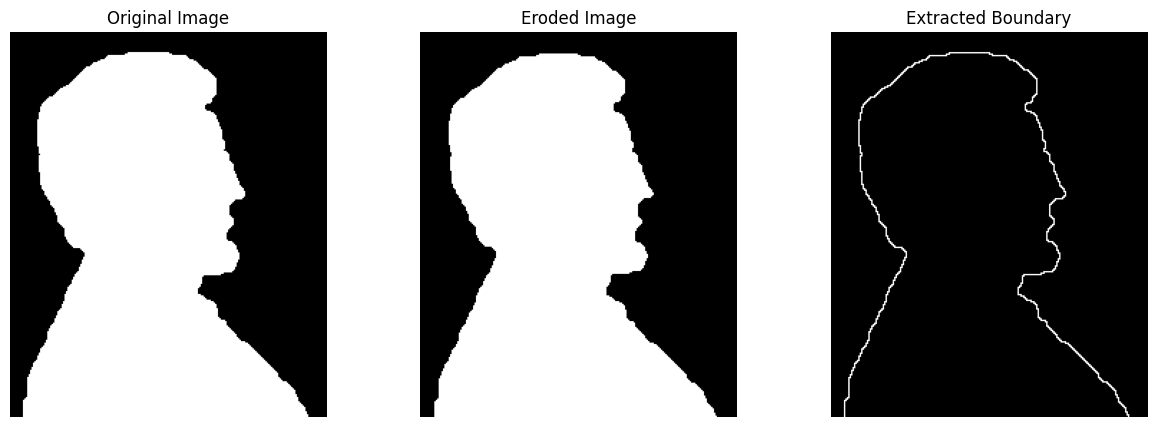

In [24]:
image = cv2.imread('Fig0914(a)(licoln from penny).tif', cv2.IMREAD_GRAYSCALE)
# Define Structuring Element (3x3)
kernel = np.ones((3,3), np.uint8)

# 1. Erode the image (Shrink it)
erosion = cv2.erode(image, kernel, iterations=1)

# 2. Subtract Erosion from Original to get Boundary
boundary = image - erosion

show_images([image, erosion, boundary], 
            ["Original Image", "Eroded Image", "Extracted Boundary"])

## 5. Thinning & Thickening
Thinning reduces objects to lines that are 1 pixel wide (Skeletonization). It is used for character recognition and fingerprint analysis.Thickening is the dual of thinning; it grows selected regions. Practically, thickening is often done by thinning the background.<br>**Math Concepts:**<br>
- Thinning: $A \otimes B = A - (A \circledast B)$ (Hit-or-Miss subtraction)<br>
- Thickening: Thickening $A$ is equivalent to Thinning $A^c$ (The Background).Note: OpenCV has a specialized thinning function in the ximgproc module, but we can also implement thickening by thinning the background.

In [11]:
# Check if ximgproc is available (requires opencv-contrib-python)
try:
    # Create an image with thick letters
    img_txt = np.zeros((100, 300), dtype=np.uint8)
    cv2.putText(img_txt, "ABC", (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 3, 255, 15)

    # --- THINNING ---
    # Zhang-Suen Thinning Algorithm
    thinned = cv2.ximgproc.thinning(img_txt, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

    # --- THICKENING ---
    # Thickening is often calculated as: Complement -> Thin -> Complement
    img_inv = cv2.bitwise_not(img_txt)
    thinned_bg = cv2.ximgproc.thinning(img_inv, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    thickened = cv2.bitwise_not(thinned_bg)

    show_images([img_txt, thinned, thickened], 
                ["Original Thick Text", "Thinned (Skeleton)", "Thickened (via Dual)"])

except AttributeError:
    print("Error: 'cv2.ximgproc' not found.")
    print("To run Thinning, please install the contrib package:")
    print("!pip install opencv-contrib-python")

Error: 'cv2.ximgproc' not found.
To run Thinning, please install the contrib package:
!pip install opencv-contrib-python


## 6. Gray Level Morphology
Morphology isn't just for binary images. It works on grayscale intensities11.<br>
- Gradient: $g = (f \oplus b) - (f \ominus b)$ (Highlights edges)
- Top Hat: $g_{top} = f - (f \circ b)$ (Highlights bright details)

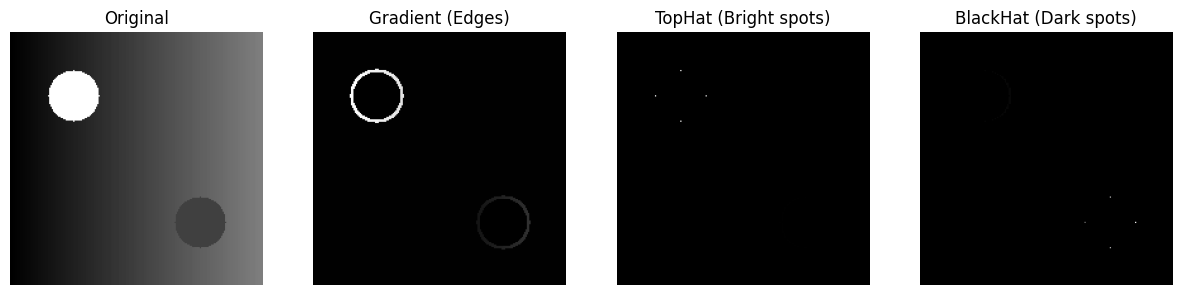

In [14]:
# Load a grayscale image
# (Generating a synthetic gradient image with shapes)
gray_img = np.zeros((200, 200), dtype=np.uint8)
for i in range(200): gray_img[:, i] = i // 2  # Gradient background
cv2.circle(gray_img, (50, 50), 20, 200, -1)   # Bright object
cv2.circle(gray_img, (150, 150), 20, 50, -1)  # Dark object

kernel = np.ones((5,5), np.uint8)
kernelgrad=np.array([[1, 1, 1], [1, -9, 1], [1, 1, 1]])

# Operations
gradient = cv2.morphologyEx(gray_img, cv2.MORPH_GRADIENT, kernelgrad)
tophat = cv2.morphologyEx(gray_img, cv2.MORPH_TOPHAT, kernelgrad)
blackhat = cv2.morphologyEx(gray_img, cv2.MORPH_BLACKHAT, kernelgrad)

show_images([gray_img, gradient, tophat, blackhat], 
            ["Original", "Gradient (Edges)", "TopHat (Bright spots)", "BlackHat (Dark spots)"])

#### Dilation & Erosion
 **Dilation:** Replaces a pixel with the maximum value in its neighborhood. This expands bright regions and shrinks dark regions.<br>**Formula:** $(f \oplus b)(x,y) = \max_{(s,t) \in b} \{ f(x-s, y-t) \}$ <br><br>**Erosion:** Replaces a pixel with the minimum value in its neighborhood. This expands dark regions and shrinks bright regions.<br>**Formula:** $(f \ominus b)(x,y) = \min_{(s,t) \in b} \{ f(x-s, y-t) \}$

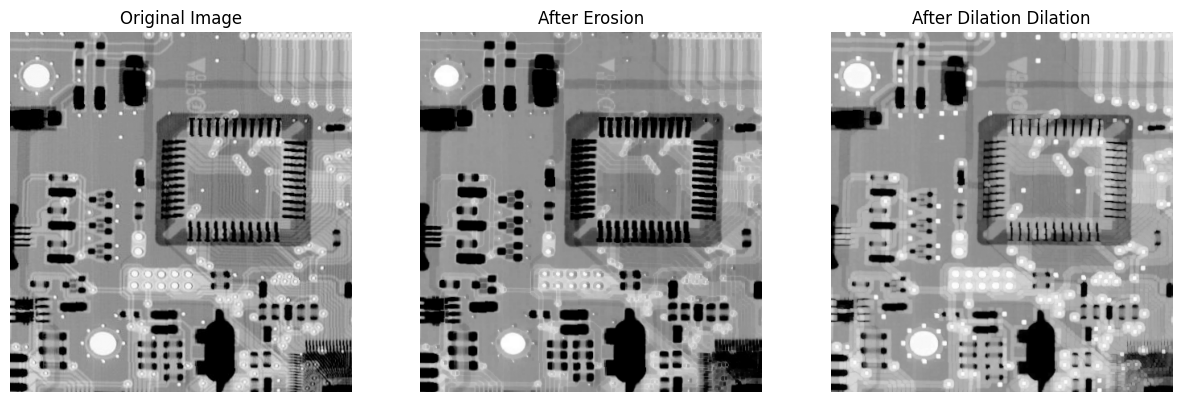

In [27]:
img=cv2.imread("Fig0935(a)(ckt_board_section).tif",0)
se=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
img_erode=cv2.erode(img,se)
img_dilate=cv2.dilate(img,se)

show_images([img, img_erode, img_dilate], ["Original Image", "After Erosion", "After Dilation Dilation"])

### Opening & Closing 
Just like in binary morphology, these are combinations of erosion and dilation, but used for image smoothing and feature filtering.<br>
- **Opening ($f \circ b$):** Erosion followed by Dilation.
  - Effect: Removes small bright details (light spots) from a dark background while keeping the overall brightness levels intact.
- Closing ($f \bullet b$): Dilation followed by Erosion.
  - Effect: Removes small dark details (dark spots) from a bright background.

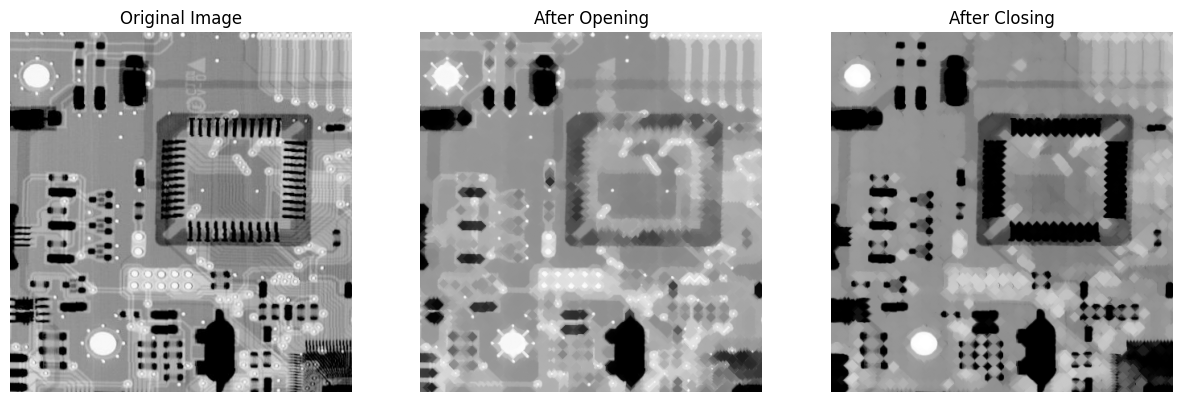

In [28]:
img=cv2.imread("Fig0935(a)(ckt_board_section).tif",0)
se=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
img_open=cv2.morphologyEx(img,cv2.MORPH_CLOSE,se,iterations=5)
img_close=cv2.morphologyEx(img,cv2.MORPH_OPEN,se,iterations=5)

show_images([img, img_open, img_close], ["Original Image", "After Opening", "After Closing"])

## 7. Connected Components Labeling & Region Properties


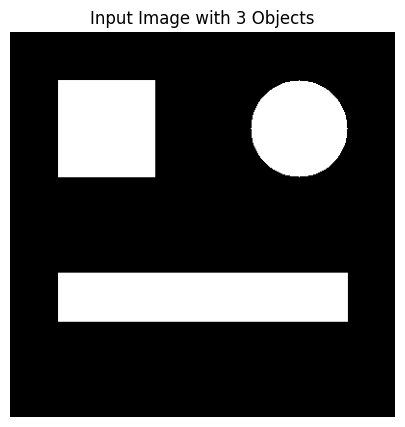

In [29]:
# 1. Create a blank black image
img_shapes = np.zeros((400, 400), dtype=np.uint8)

# 2. Draw Objects (Foreground = 255)
# Object 1: Square (Top Left)
cv2.rectangle(img_shapes, (50, 50), (150, 150), 255, -1)

# Object 2: Circle (Top Right)
cv2.circle(img_shapes, (300, 100), 50, 255, -1)

# Object 3: Rectangle (Bottom)
cv2.rectangle(img_shapes, (50, 250), (350, 300), 255, -1)

# Display the Starting Image
show_images([img_shapes], ["Input Image with 3 Objects"])

#### **1. Connected Components Labeling**

**Concept:**
Connected Components Labeling (CCL) scans a binary image to detect distinct regions (objects). It groups pixels that are "connected" (share an edge or corner) and assigns a unique **Label ID** to each group[cite: 159, 161].

**The Algorithm:**
1.  Scan the image pixel-by-pixel.
2.  Check neighbors (using 4-connectivity or 8-connectivity).
3.  If a neighbor has a label, copy it. If neighbors have different labels, record them as "equivalent" to merge later [cite: 173-179].

**Goal:**
To transform a binary image (0s and 1s) into a "Labeled Image" where every object has a distinct integer ID (1, 2, 3...).

Total unique labels found: 4
(Label 0 is always the background)


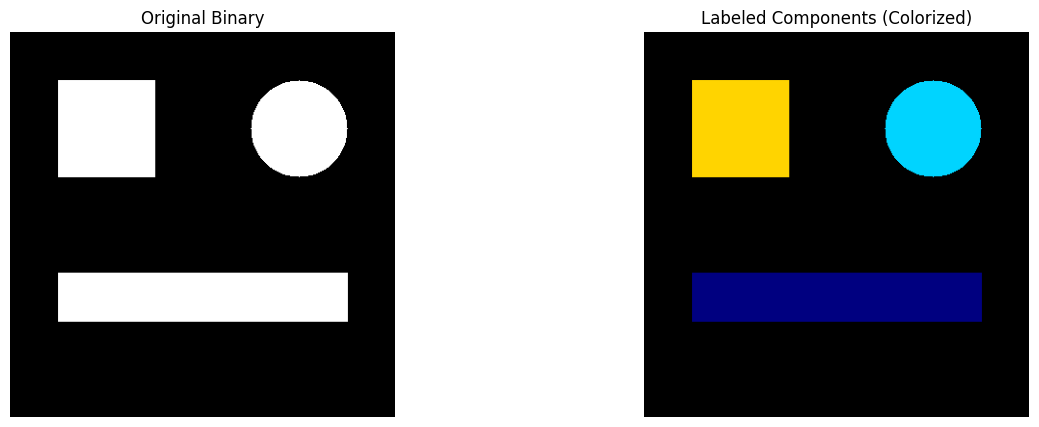

In [30]:
# Apply Connected Components Labeling (8-connectivity)
# 'stats' contains position/area info, 'centroids' contains center of mass
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_shapes, connectivity=8)

print(f"Total unique labels found: {num_labels}")
print("(Label 0 is always the background)")

# Visualize the Labels
# We normalize the labels to 0-255 just to see them clearly in grayscale
labels_vis = (labels * (255 / (num_labels - 1))).astype(np.uint8)

# Apply a colormap for better visualization
labels_color = cv2.applyColorMap(labels_vis, cv2.COLORMAP_JET)
# Set background (label 0) to black manually for clarity
labels_color[labels == 0] = [0, 0, 0]

show_images([img_shapes, labels_color], ["Original Binary", "Labeled Components (Colorized)"])

#### **2. Geometric Properties: Area & Centroid**

Once we have labeled objects, we can measure them.

**Area ($A$):**
The total number of pixels in the region $R$[cite: 206].
$$A = \sum_{(r,c) \in R} 1$$

**Centroid ($\bar{r}, \bar{c}$):**
The geometric center (center of mass) of the region [cite: 208-210].
$$\bar{r} = \frac{1}{A} \sum_{(r,c) \in R} r, \quad \bar{c} = \frac{1}{A} \sum_{(r,c) \in R} c$$
*Note: In image processing, $r$ corresponds to $y$ (rows) and $c$ corresponds to $x$ (columns).*

ID    Area       Centroid (x, y)
-----------------------------------
1     10201      (100.0, 100.0)
2     7845       (300.0, 100.0)
3     15351      (200.0, 275.0)


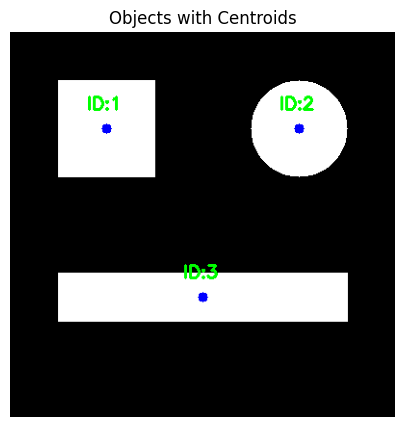

In [31]:
# Prepare an image to draw text on
out_img_stats = cv2.cvtColor(img_shapes, cv2.COLOR_GRAY2BGR)

print(f"{'ID':<5} {'Area':<10} {'Centroid (x, y)'}")
print("-" * 35)

# Skip label 0 (Background)
for i in range(1, num_labels):
    
    # 1. Get Area directly from stats
    area = stats[i, cv2.CC_STAT_AREA]
    
    # 2. Get Centroid
    cx, cy = centroids[i]
    
    print(f"{i:<5} {area:<10} ({cx:.1f}, {cy:.1f})")
    
    # Visualisation
    # Draw a red dot at the centroid
    cv2.circle(out_img_stats, (int(cx), int(cy)), 5, (0, 0, 255), -1)
    # Put Label ID text
    cv2.putText(out_img_stats, f"ID:{i}", (int(cx)-20, int(cy)-20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

show_images([out_img_stats], ["Objects with Centroids"])

#### **4. Geometric Properties: Perimeter & Circularity**

**Perimeter ($P$):**
The length of the boundary of the region. It counts pixels on the edge of the object[cite: 214, 218].

**Circularity:**
A measure of how "round" a shape is.
$$C_1 = \frac{P^2}{A}$$
* **Circle:** Has the minimum possible value ($4\pi \approx 12.57$).
* **Square:** Has a value of 16.
* **Elongated Shapes:** Have much higher values.
This property is **Structural**, allowing us to classify shapes mathematically.

ID    Perimeter    Circularity     Prediction
--------------------------------------------------
1     400.0        15.68           Square
2     329.7        13.86           Circle
3     700.0        31.92           Rectangle


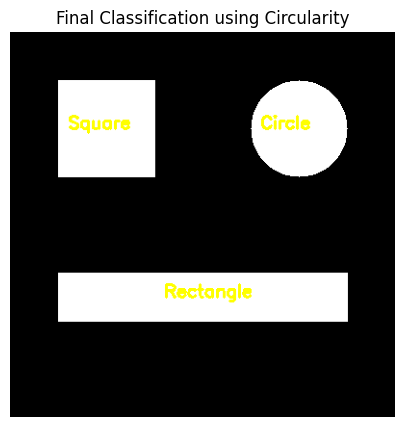

In [32]:
out_img_final = cv2.cvtColor(img_shapes, cv2.COLOR_GRAY2BGR)

print(f"{'ID':<5} {'Perimeter':<12} {'Circularity':<15} {'Prediction'}")
print("-" * 50)

for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    
    # 1. Find Perimeter using Contours
    # Create a mask for just this single object
    obj_mask = (labels == i).astype(np.uint8) * 255
    contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # arcLength calculates perimeter
    perimeter = cv2.arcLength(contours[0], True)
    
    # 2. Calculate Circularity (P^2 / A)
    circularity = (perimeter ** 2) / area
    
    # 3. Classify based on Math
    if circularity < 14.0:
        shape_type = "Circle"
    elif 15.0 < circularity < 17.0:
        shape_type = "Square"
    else:
        shape_type = "Rectangle"

    print(f"{i:<5} {perimeter:<12.1f} {circularity:<15.2f} {shape_type}")
    
    # Draw Classification on Image
    cx, cy = centroids[i]
    cv2.putText(out_img_final, shape_type, (int(cx)-40, int(cy)), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

show_images([out_img_final], ["Final Classification using Circularity"])

#### **3. Geometric Properties: Bounding Box**

**Definition:**
The Bounding Box is the smallest rectangle that can completely enclose the object. It is defined by four coordinates: topmost, bottommost, leftmost, and rightmost [cite: 258-261].

**Usage:**
It gives a rough idea of the object's placement and size without processing the complex shape.

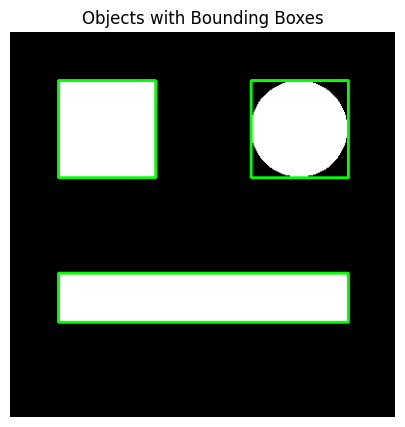

In [33]:
out_img_box = cv2.cvtColor(img_shapes, cv2.COLOR_GRAY2BGR)

# 'stats' contains position/area info, 'centroids' contains center of mass
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_shapes, connectivity=8)

for i in range(1, num_labels):
    # Extract Bounding Box coordinates from stats
    # x (left), y (top), w (width), h (height)
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    
    # Draw the Rectangle (Green)
    cv2.rectangle(out_img_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

show_images([out_img_box], ["Objects with Bounding Boxes"])

## **5. Statistical Analysis Table**

Instead of just visualizing the data on the image, it is standard practice in Computer Vision to export these properties into a structured table (like a DataFrame). This allows for filtering, sorting, and further analysis (e.g., "Find all objects with Area > 500").

We will calculate **Area**, **Perimeter**, **Circularity**, **Centroid**, and **Bounding Box** for every labeled object and present it as a clean table.

In [34]:
import pandas as pd

# Initialize a list to store our data
data_list = []

print("Generating Geometric Properties Table...")

for i in range(1, num_labels): # Iterate through objects (skipping 0-background)
    # 1. Basic Stats (from connectedComponents)
    area = stats[i, cv2.CC_STAT_AREA]
    x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
    cx, cy = centroids[i]
    
    # 2. Advanced Stats (Contours)
    obj_mask = (labels == i).astype(np.uint8) * 255
    contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    perimeter = cv2.arcLength(contours[0], True)
    
    # 3. Circularity Metric (P^2 / A)
    circularity = (perimeter ** 2) / area if area > 0 else 0
    
    # [cite_start]4. Shape Estimation based on Circularity [cite: 226]
    # Circle ~ 12.57, Square ~ 16, Rectangle > 18
    if circularity < 14.5: shape_type = "Circle"
    elif 15.0 < circularity < 17.5: shape_type = "Square"
    else: shape_type = "Rectangle"

    # Append to list
    data_list.append({
        "Label ID": i,
        "Shape Prediction": shape_type,
        "Area (px)": area,
        "Perimeter (px)": round(perimeter, 2),
        "Circularity": round(circularity, 2),
        "Centroid (x,y)": (round(cx, 1), round(cy, 1)),
        "Bounding Box": f"[{x}, {y}, {w}, {h}]"
    })

# Create and Display Pandas DataFrame
df = pd.DataFrame(data_list)

# Display the table
# If running in Jupyter, 'display(df)' renders a nice HTML table. 
# If in console, 'print(df)' works too.
try:
    display(df)
except NameError:
    print(df)

Generating Geometric Properties Table...


,Label ID,Shape Prediction,Area (px),Perimeter (px),Circularity,"Centroid (x,y)",Bounding Box
0,1,Square,10201,400.00,15.68,"(100.0, 100.0)","[50, 50, 101, 101]"
1,2,Circle,7845,329.71,13.86,"(300.0, 100.0)","[250, 50, 101, 101]"
2,3,Rectangle,15351,700.00,31.92,"(200.0, 275.0)","[50, 250, 301, 51]"


## **6. Final Lab Summary: Geometric Properties Gallery**

Here we visualize the entire pipeline for Connected Components and Region Analysis. 

**The Gallery:**
1.  **Original Input:** The binary shapes.
2.  **Labeled Components:** Each object gets a unique color ID.
3.  **Centroids:** The calculated center of mass for each object.
4.  **Bounding Boxes:** The extent (width/height) of each object.
5.  **Shape Classification:** The final result using Circularity to identify the shape.

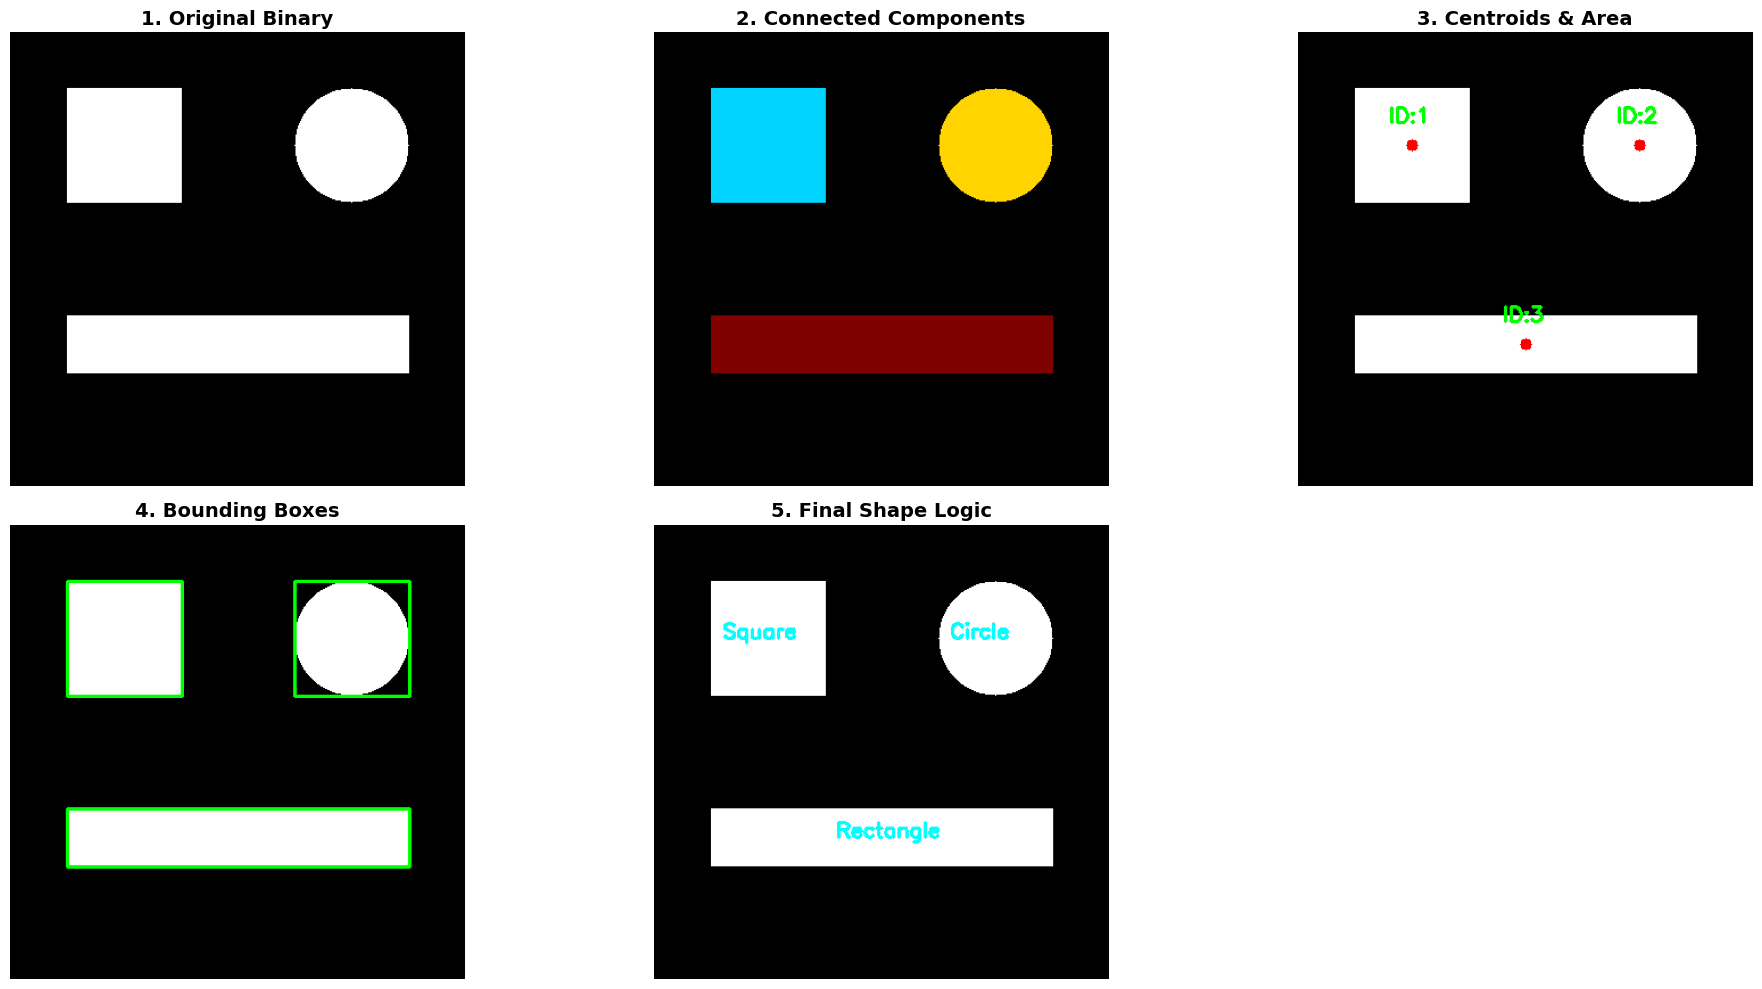

In [36]:
# Collect all the images we generated in previous steps
# (Ensure variables: img_shapes, labels_color, out_img_stats, out_img_box, out_img_final exist)

images_to_show = [
    img_shapes,       # 1. Original
    labels_color,     # 2. Labeled
    out_img_stats,    # 3. Centroids/Area
    out_img_box,      # 4. Bounding Boxes
    out_img_final     # 5. Final Classification
]

titles = [
    "1. Original Binary",
    "2. Connected Components",
    "3. Centroids & Area",
    "4. Bounding Boxes",
    "5. Final Shape Logic"
]

# Plotting
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(2, 3, i+1) # Grid of 2 Rows, 3 Columns
    
    # If image is grayscale (2D), convert to RGB for consistent display
    if len(images_to_show[i].shape) == 2:
        plt.imshow(images_to_show[i], cmap='gray')
    else:
        # OpenCV uses BGR, Matplotlib uses RGB. Flip color channels.
        plt.imshow(cv2.cvtColor(images_to_show[i], cv2.COLOR_BGR2RGB))
        
    plt.title(titles[i], fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()